In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [2]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [3]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [4]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [5]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [6]:
class_num = len(targets)

In [7]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [8]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

In [9]:
import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [10]:
X_train = norm_quat(X_train)
X_test = norm_quat(X_test)

In [11]:
def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

In [12]:
def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

In [13]:
ang_list = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

In [14]:
cos_list = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z']

for data in [X_train, X_test]:
    for col in cos_list:
        data[col + '_cos'] = np.cos(data[col].values)

In [15]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,angular_velocity_X_cos,angular_velocity_Y_cos,angular_velocity_Z_cos
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.994211,0.999846,1.000000
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.997699,0.999552,0.999994
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.999974,0.999581,0.999982
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.999915,0.999811,0.999960
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999987,0.999971,0.999986


In [16]:
def feat_eng(df):
    data = pd.DataFrame()
    df['linear_acceleration_Z'] += 9.80665
    #df['eulerX-Z'] = df['euler_X']-df['euler_Z']
    df['total_acce'] = (df['linear_acceleration_X']**2 + df['linear_acceleration_Y']**2 + df['linear_acceleration_Z']**2)**0.5
    df['total_ang_cos'] = (df['angular_velocity_X_cos']**2 + df['angular_velocity_Y_cos']**2 + df['angular_velocity_Z_cos']**2)**0.5
    
    tmp_df = pd.concat([df['linear_acceleration_Z'], df['angular_velocity_X']], axis=1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tmp_df = scaler.fit_transform(tmp_df)
    
    #df['total_angu'] = (df['angular_velocity_X']**2 + df['angular_velocity_Y']**2 + df['angular_velocity_Z']**2)**0.5
    
    #df['total_eule'] = (df['euler_X']**2 + df['euler_Y']**2 + df['euler_Z']**2)**0.5
    #df['total_xyz'] = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2)**0.5
    #df['total_acc/vel'] = df['total_acce']/df['total_angu']
    
    df_columns = df.columns[3:]
    for col in tqdm(df_columns):
        data[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        data[col + '_median'] = df.groupby(['series_id'])[col].median()
        data[col + '_max'] = df.groupby(['series_id'])[col].max()
        data[col + '_min'] = df.groupby(['series_id'])[col].min()
        data[col + '_std'] = df.groupby(['series_id'])[col].std()
        data[col + '_range'] = data[col + '_max'] - data[col + '_min']
        data[col + '_maxtoMin'] = data[col + '_max'] / data[col + '_min']
        data[col + '_mean_abs_chg'] = df.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        data[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        data[col + '_abs_max'] = df.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        data[col + '_abs_min'] = df.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        data[col + '_abs_avg'] = (data[col + '_abs_min'] + data[col + '_abs_max'])/2
        
        
    #data['corr_linZangX'] = np.correlate(np.abs(tmp_df[:, 0]), np.abs(tmp_df[:, 1]))
    return data

In [17]:
X_train = feat_eng(X_train)
X_test = feat_eng(X_test)

100%|██████████| 15/15 [00:32<00:00,  2.10s/it]


In [18]:
data_col = X_train.columns

In [19]:
for data in [X_train, X_test]:
    data.fillna(0,inplace=True)
    data.replace(-np.inf,0,inplace=True)
    data.replace(np.inf,0,inplace=True)

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
N_SPLITS = 5

In [22]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [23]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

In [24]:
y = np.concatenate((np.zeros(len(X_train)), np.ones(len(X_test))), axis=0)
X = np.concatenate((X_train, X_test), axis=0)

In [25]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))

clf_2 = []
val_roc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'binary_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary',
               #'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in splits:
    X_tr, y_tr = X[train_idx, :], y[train_idx]
    X_val, y_val = X[val_idx, :], y[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)
    
    val_roc.append(roc_auc_score(y_val, (pred_lgb>0.5).astype(int)))
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=0)
    
    clf_2.append(model_lgb)

[1]	valid_0's binary_logloss: 0.679643
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.667879
[3]	valid_0's binary_logloss: 0.660293
[4]	valid_0's binary_logloss: 0.653022
[5]	valid_0's binary_logloss: 0.644663
[6]	valid_0's binary_logloss: 0.63505
[7]	valid_0's binary_logloss: 0.62764
[8]	valid_0's binary_logloss: 0.620557
[9]	valid_0's binary_logloss: 0.615706
[10]	valid_0's binary_logloss: 0.611786
[11]	valid_0's binary_logloss: 0.606861
[12]	valid_0's binary_logloss: 0.601925
[13]	valid_0's binary_logloss: 0.596535
[14]	valid_0's binary_logloss: 0.592449
[15]	valid_0's binary_logloss: 0.588822
[16]	valid_0's binary_logloss: 0.586903
[17]	valid_0's binary_logloss: 0.583443
[18]	valid_0's binary_logloss: 0.581986
[19]	valid_0's binary_logloss: 0.579034
[20]	valid_0's binary_logloss: 0.577162
[21]	valid_0's binary_logloss: 0.575527
[22]	valid_0's binary_logloss: 0.572487
[23]	valid_0's binary_logloss: 0.571147
[24]	valid_0's binary_logloss

[204]	valid_0's binary_logloss: 0.497695
[205]	valid_0's binary_logloss: 0.497184
[206]	valid_0's binary_logloss: 0.496798
[207]	valid_0's binary_logloss: 0.4964
[208]	valid_0's binary_logloss: 0.496154
[209]	valid_0's binary_logloss: 0.49618
[210]	valid_0's binary_logloss: 0.496387
[211]	valid_0's binary_logloss: 0.495958
[212]	valid_0's binary_logloss: 0.496567
[213]	valid_0's binary_logloss: 0.496357
[214]	valid_0's binary_logloss: 0.496459
[215]	valid_0's binary_logloss: 0.495906
[216]	valid_0's binary_logloss: 0.495913
[217]	valid_0's binary_logloss: 0.4959
[218]	valid_0's binary_logloss: 0.495621
[219]	valid_0's binary_logloss: 0.495622
[220]	valid_0's binary_logloss: 0.495443
[221]	valid_0's binary_logloss: 0.495647
[222]	valid_0's binary_logloss: 0.495669
[223]	valid_0's binary_logloss: 0.495716
[224]	valid_0's binary_logloss: 0.495443
[225]	valid_0's binary_logloss: 0.495497
[226]	valid_0's binary_logloss: 0.495455
[227]	valid_0's binary_logloss: 0.495454
[228]	valid_0's binar

[52]	valid_0's binary_logloss: 0.542784
[53]	valid_0's binary_logloss: 0.542013
[54]	valid_0's binary_logloss: 0.5412
[55]	valid_0's binary_logloss: 0.541089
[56]	valid_0's binary_logloss: 0.539962
[57]	valid_0's binary_logloss: 0.54006
[58]	valid_0's binary_logloss: 0.539591
[59]	valid_0's binary_logloss: 0.539256
[60]	valid_0's binary_logloss: 0.539365
[61]	valid_0's binary_logloss: 0.53899
[62]	valid_0's binary_logloss: 0.538494
[63]	valid_0's binary_logloss: 0.538888
[64]	valid_0's binary_logloss: 0.539361
[65]	valid_0's binary_logloss: 0.53891
[66]	valid_0's binary_logloss: 0.538684
[67]	valid_0's binary_logloss: 0.537596
[68]	valid_0's binary_logloss: 0.536182
[69]	valid_0's binary_logloss: 0.536012
[70]	valid_0's binary_logloss: 0.534032
[71]	valid_0's binary_logloss: 0.533645
[72]	valid_0's binary_logloss: 0.532997
[73]	valid_0's binary_logloss: 0.532793
[74]	valid_0's binary_logloss: 0.532967
[75]	valid_0's binary_logloss: 0.532884
[76]	valid_0's binary_logloss: 0.532507
[77]	

[267]	valid_0's binary_logloss: 0.493267
[268]	valid_0's binary_logloss: 0.493076
[269]	valid_0's binary_logloss: 0.493469
[270]	valid_0's binary_logloss: 0.493357
[271]	valid_0's binary_logloss: 0.49268
[272]	valid_0's binary_logloss: 0.492924
[273]	valid_0's binary_logloss: 0.493124
[274]	valid_0's binary_logloss: 0.493435
[275]	valid_0's binary_logloss: 0.493947
[276]	valid_0's binary_logloss: 0.494022
[277]	valid_0's binary_logloss: 0.493966
[278]	valid_0's binary_logloss: 0.493722
[279]	valid_0's binary_logloss: 0.493714
[280]	valid_0's binary_logloss: 0.493724
[281]	valid_0's binary_logloss: 0.493871
[282]	valid_0's binary_logloss: 0.493757
[283]	valid_0's binary_logloss: 0.494329
[284]	valid_0's binary_logloss: 0.494721
[285]	valid_0's binary_logloss: 0.493906
[286]	valid_0's binary_logloss: 0.494017
[287]	valid_0's binary_logloss: 0.493824
[288]	valid_0's binary_logloss: 0.492693
[289]	valid_0's binary_logloss: 0.493144
[290]	valid_0's binary_logloss: 0.492972
[291]	valid_0's b

[85]	valid_0's binary_logloss: 0.53485
[86]	valid_0's binary_logloss: 0.534928
[87]	valid_0's binary_logloss: 0.534387
[88]	valid_0's binary_logloss: 0.533232
[89]	valid_0's binary_logloss: 0.533212
[90]	valid_0's binary_logloss: 0.532195
[91]	valid_0's binary_logloss: 0.531836
[92]	valid_0's binary_logloss: 0.531847
[93]	valid_0's binary_logloss: 0.53155
[94]	valid_0's binary_logloss: 0.531939
[95]	valid_0's binary_logloss: 0.531732
[96]	valid_0's binary_logloss: 0.530713
[97]	valid_0's binary_logloss: 0.530162
[98]	valid_0's binary_logloss: 0.53039
[99]	valid_0's binary_logloss: 0.530335
[100]	valid_0's binary_logloss: 0.53038
[101]	valid_0's binary_logloss: 0.530169
[102]	valid_0's binary_logloss: 0.529916
[103]	valid_0's binary_logloss: 0.529652
[104]	valid_0's binary_logloss: 0.529099
[105]	valid_0's binary_logloss: 0.52923
[106]	valid_0's binary_logloss: 0.529204
[107]	valid_0's binary_logloss: 0.528747
[108]	valid_0's binary_logloss: 0.528458
[109]	valid_0's binary_logloss: 0.52

[40]	valid_0's binary_logloss: 0.546616
[41]	valid_0's binary_logloss: 0.545975
[42]	valid_0's binary_logloss: 0.545465
[43]	valid_0's binary_logloss: 0.544895
[44]	valid_0's binary_logloss: 0.545118
[45]	valid_0's binary_logloss: 0.545149
[46]	valid_0's binary_logloss: 0.544853
[47]	valid_0's binary_logloss: 0.544534
[48]	valid_0's binary_logloss: 0.541978
[49]	valid_0's binary_logloss: 0.541245
[50]	valid_0's binary_logloss: 0.540418
[51]	valid_0's binary_logloss: 0.539414
[52]	valid_0's binary_logloss: 0.538602
[53]	valid_0's binary_logloss: 0.538207
[54]	valid_0's binary_logloss: 0.536035
[55]	valid_0's binary_logloss: 0.536075
[56]	valid_0's binary_logloss: 0.535525
[57]	valid_0's binary_logloss: 0.534863
[58]	valid_0's binary_logloss: 0.535252
[59]	valid_0's binary_logloss: 0.534471
[60]	valid_0's binary_logloss: 0.534518
[61]	valid_0's binary_logloss: 0.533433
[62]	valid_0's binary_logloss: 0.531763
[63]	valid_0's binary_logloss: 0.532037
[64]	valid_0's binary_logloss: 0.531018


[281]	valid_0's binary_logloss: 0.49343
[282]	valid_0's binary_logloss: 0.493562
[283]	valid_0's binary_logloss: 0.493596
[284]	valid_0's binary_logloss: 0.492694
[285]	valid_0's binary_logloss: 0.492677
[286]	valid_0's binary_logloss: 0.493101
[287]	valid_0's binary_logloss: 0.493152
[288]	valid_0's binary_logloss: 0.493496
[289]	valid_0's binary_logloss: 0.493648
[290]	valid_0's binary_logloss: 0.493508
[291]	valid_0's binary_logloss: 0.493651
[292]	valid_0's binary_logloss: 0.493656
[293]	valid_0's binary_logloss: 0.493879
[294]	valid_0's binary_logloss: 0.493707
[295]	valid_0's binary_logloss: 0.493506
[296]	valid_0's binary_logloss: 0.492893
[297]	valid_0's binary_logloss: 0.492855
[298]	valid_0's binary_logloss: 0.493493
[299]	valid_0's binary_logloss: 0.493381
[300]	valid_0's binary_logloss: 0.493709
[301]	valid_0's binary_logloss: 0.493627
[302]	valid_0's binary_logloss: 0.493557
[303]	valid_0's binary_logloss: 0.493902
[304]	valid_0's binary_logloss: 0.494082
[305]	valid_0's b

[175]	valid_0's binary_logloss: 0.482401
[176]	valid_0's binary_logloss: 0.482311
[177]	valid_0's binary_logloss: 0.482587
[178]	valid_0's binary_logloss: 0.482489
[179]	valid_0's binary_logloss: 0.48236
[180]	valid_0's binary_logloss: 0.482743
[181]	valid_0's binary_logloss: 0.482845
[182]	valid_0's binary_logloss: 0.482711
[183]	valid_0's binary_logloss: 0.48269
[184]	valid_0's binary_logloss: 0.482846
[185]	valid_0's binary_logloss: 0.482757
[186]	valid_0's binary_logloss: 0.481996
[187]	valid_0's binary_logloss: 0.4822
[188]	valid_0's binary_logloss: 0.482073
[189]	valid_0's binary_logloss: 0.481651
[190]	valid_0's binary_logloss: 0.481087
[191]	valid_0's binary_logloss: 0.481048
[192]	valid_0's binary_logloss: 0.480844
[193]	valid_0's binary_logloss: 0.480937
[194]	valid_0's binary_logloss: 0.480458
[195]	valid_0's binary_logloss: 0.480221
[196]	valid_0's binary_logloss: 0.480064
[197]	valid_0's binary_logloss: 0.479775
[198]	valid_0's binary_logloss: 0.479652
[199]	valid_0's bina

[415]	valid_0's binary_logloss: 0.456142
[416]	valid_0's binary_logloss: 0.456296
[417]	valid_0's binary_logloss: 0.455907
[418]	valid_0's binary_logloss: 0.455809
[419]	valid_0's binary_logloss: 0.45643
[420]	valid_0's binary_logloss: 0.456046
[421]	valid_0's binary_logloss: 0.455798
[422]	valid_0's binary_logloss: 0.455812
[423]	valid_0's binary_logloss: 0.455718
[424]	valid_0's binary_logloss: 0.456034
[425]	valid_0's binary_logloss: 0.456014
[426]	valid_0's binary_logloss: 0.455995
[427]	valid_0's binary_logloss: 0.456097
[428]	valid_0's binary_logloss: 0.456067
[429]	valid_0's binary_logloss: 0.455648
[430]	valid_0's binary_logloss: 0.455486
[431]	valid_0's binary_logloss: 0.455734
[432]	valid_0's binary_logloss: 0.455998
[433]	valid_0's binary_logloss: 0.456131
[434]	valid_0's binary_logloss: 0.456323
[435]	valid_0's binary_logloss: 0.456428
[436]	valid_0's binary_logloss: 0.456671
[437]	valid_0's binary_logloss: 0.456477
[438]	valid_0's binary_logloss: 0.456579
[439]	valid_0's b

In [26]:
val_roc

[0.7667116708578967,
 0.759335128980437,
 0.7501479172901552,
 0.7665581366549364,
 0.7685214806864737]

In [27]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf_2:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
orientation_Z_min,3972.924567
orientation_X_min,3904.736377
orientation_X_max,3422.874152
orientation_Z_max,2969.652738
orientation_X_abs_max,2849.885618
orientation_W_maxtoMin,2697.507417
orientation_Z_abs_max,2695.216755
orientation_Y_maxtoMin,2665.241932
orientation_Z_mean,2659.935283
orientation_Z_abs_min,2564.460769


In [28]:
adv_val = []
for model in clf_2:
    adv_val.append(model.predict(X_train))

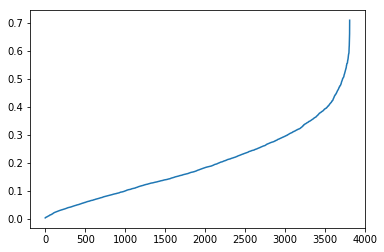

In [29]:
plt.plot(np.sort(np.mean(adv_val, axis=0)))

In [30]:
group = y_train['group_id'].values

In [35]:
splits = GroupKFold(n_splits=4).split(X_train, y_id, group)

In [36]:
#splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))

clf = []
val_acc = []
val_pred = pd.DataFrame()

lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'multi_logloss',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'multiclass',
               'num_class': class_num,
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }

for train_idx, val_idx in splits:
    X_tr, y_tr = X_train[train_idx, :], y_id[train_idx]
    X_val, y_val = X_train[val_idx, :], y_id[val_idx]
    
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30)
    pred_lgb = model_lgb.predict(X_val)

    val_acc.append(accuracy_score(y_val, np.argmax(pred_lgb, axis=1)))

#pred_lgb = pd.DataFrame(pred_lgb, index=np.where(np.mean(adv_val, axis=0)>0.3))
#val_pred = pd.concat([val_pred, pred_lgb], axis=0)

clf.append(model_lgb)

[1]	valid_0's multi_logloss: 2.00714
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.96018
[3]	valid_0's multi_logloss: 1.93506
[4]	valid_0's multi_logloss: 1.90624
[5]	valid_0's multi_logloss: 1.88846
[6]	valid_0's multi_logloss: 1.87549
[7]	valid_0's multi_logloss: 1.86574
[8]	valid_0's multi_logloss: 1.86217
[9]	valid_0's multi_logloss: 1.85733
[10]	valid_0's multi_logloss: 1.85026
[11]	valid_0's multi_logloss: 1.85447
[12]	valid_0's multi_logloss: 1.85922
[13]	valid_0's multi_logloss: 1.86254
[14]	valid_0's multi_logloss: 1.86474
[15]	valid_0's multi_logloss: 1.86648
[16]	valid_0's multi_logloss: 1.87179
[17]	valid_0's multi_logloss: 1.87891
[18]	valid_0's multi_logloss: 1.88022
[19]	valid_0's multi_logloss: 1.8913
[20]	valid_0's multi_logloss: 1.89956
[21]	valid_0's multi_logloss: 1.90931
[22]	valid_0's multi_logloss: 1.91821
[23]	valid_0's multi_logloss: 1.92554
[24]	valid_0's multi_logloss: 1.93615
[25]	valid_0's multi_logloss: 1.9484

In [37]:
val_acc

[0.41028331584470096,
 0.39664218258132217,
 0.45473684210526316,
 0.519916142557652]

In [39]:
np.mean(val_acc)

0.4453946207722346

In [38]:
feature_imp = np.zeros(X_train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp, index=data_col).sort_values(by=0, ascending=False)

,0
orientation_X_mean,2299.720829
orientation_X_min,2083.555663
orientation_Z_max,2081.858058
angular_velocity_Y_mean_abs_chg,1871.111821
linear_acceleration_X_mean_abs_chg,1712.301320
total_acce_mean_abs_chg,1660.780938
angular_velocity_Z_min,1421.037284
total_ang_cos_mean_abs_chg,1324.676012
orientation_X_max,1295.773018
orientation_W_abs_max,1289.154999


In [ ]:
preds_test = []

for model in clf:
    preds_test.append(model.predict(X_test))

In [ ]:
preds_test = np.argmax(np.mean(preds_test, axis=0), axis=1)

In [ ]:
test_surface = []
for i in preds_test:
    test_surface.append(id_to_target[i])

In [ ]:
test_surface = np.asarray(test_surface)

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')

In [ ]:
submission['surface'] = test_surface
submission.to_csv('../output/submission_1.csv', index=False)
submission.head()